# Recommendations with IBM

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle


%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
# df.head()

In [2]:
# Show df_content to get an idea of the data
# df_content.head()

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?  

In [53]:
article_interactions = df.groupby(['email']).count()
article_interactions
article_interactions_count = list(article_interactions.title)


Text(0, 0.5, 'Interactions')

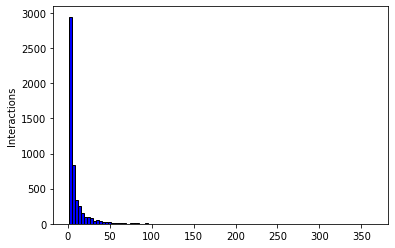

In [54]:
# matplotlib histogram
plt.hist(article_interactions_count, color = 'blue', edgecolor = 'black',
         bins = 100)
# Add labels
plt.ylabel('Interactions')

In [55]:
# Fill in the median and maximum number of user_article interactios below
import statistics as st
import math as math

median = st.median(article_interactions_count)
variance = st.pvariance(article_interactions_count)
devia = math.sqrt(variance)
devia

median_val = median # 50% of individuals interact with 3 articles or fewer.
max_views_by_user = max(article_interactions_count)# The maximum number of user-article interactions by any 1 user is 364.
# max_views_by_user

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [56]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset=['article_id'], keep='first')]


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [57]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [58]:
merged_df = pd.merge(df,df_content, how='outer', on = 'article_id')


articles_with_interactions = merged_df[merged_df.email.notnull()].groupby(['article_id']).count()
total_articles = df_content['article_id'].nunique()
total_articles
unique_usr = df[df.email.notnull()].groupby(['email']).count()
# df[~df.duplicated(subset=['article_id', "email"])].count()
# df[df.email.isnull()].count()
# articles_with_interactions[articles_with_interactions.email>0].count()[0]
# user_interactions = df[df.email.notnull()].groupby(['article_id']).count()



(45993, 3)

In [59]:
unique_articles = articles_with_interactions[articles_with_interactions.email>0].count()[0] # 714 - The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()  #  - The number of unique articles on the IBM platform
unique_users = unique_usr.shape[0] # 5148 - The number of unique users
user_article_interactions = df.shape[0] # 45993 The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [60]:
max(df.groupby('article_id').count()['email'])


# df[df.email.isnull()]

937

In [61]:
user_interactions = df[df.email.notnull()].groupby(['article_id']).count()
user_interactions[user_interactions.title == max(user_interactions.title)]

,title,email
article_id,,
1429.0,937,937


In [62]:
most_viewed_article_id = str(1429.0) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [63]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [65]:
df.head()
n=10
article_interactions = df.groupby('article_id').count().reset_index()
article_interactions = article_interactions.sort_values(by='title', ascending=False)
article_interactions = article_interactions.head(n)
article_interactions


idsList = list(article_interactions.article_id)
titles = df[df['article_id'].isin(idsList)]['title']
titles = titles.drop_duplicates()
titles

# artcle_titles = list(article_interactions.index)

1           healthcare python streaming application demo
2             use deep learning for image classification
14              apache spark lab, part 1: basic concepts
29     predicting churn with the spss random tree alg...
31               analyze energy consumption in buildings
37                        visualize car data with brunel
42     use xgboost, scikit-learn & ibm watson machine...
56     gosales transactions for logistic regression m...
66           insights from new york car accident reports
154    finding optimal locations of new store using d...
Name: title, dtype: object

In [66]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_interactions = df.groupby('article_id').count().reset_index()
    article_interactions = article_interactions.sort_values(by='title', ascending=False)
    article_interactions = article_interactions.head(n)
    
    idsList = list(article_interactions.article_id)
    titles = df[df['article_id'].isin(idsList)]['title']
    titles = titles.drop_duplicates()
    top_articles = list(titles)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_interactions = df.groupby('article_id').count().reset_index()
    article_interactions = article_interactions.sort_values(by='title', ascending=False)
    article_interactions = article_interactions.head(n)
    
    idsList = list(article_interactions.article_id)
#     ids = df[df['article_id'].isin(idsList)]['article_id']
#     titles = titles.drop_duplicates()
    top_articles = list(idsList)

    return top_articles # Return the top article ids

In [67]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [68]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [69]:
# df.head()
# df_pivot = df[['article_id','user_id']]
# df_pivot['present'] = 1
# df_pivot = df_pivot.drop_duplicates()
# df_pivot = df_pivot.pivot(index='user_id', columns='article_id', values='present')
# df_pivot[df_pivot.isnull()]='0'
# df_pivot.head()

In [70]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df[['article_id','user_id']]
    user_item['present'] = 1
    user_item = user_item.drop_duplicates()
    user_item = user_item.pivot(index='user_id', columns='article_id', values='present')
    user_item[user_item.isnull()]=0
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [72]:
user_id = 1
user_row = user_item.iloc[user_id]

new_mtx =  user_item.dot(user_row).reset_index()
new_mtx.rename({'0': 'similarity' }, axis=1, inplace=True)
new_mtx.columns = ['user_id', 'similarity']
new_mtx = new_mtx.sort_values(by='similarity',ascending=False )
new_mtx.head()
idList = list(new_mtx['user_id'])
# idList.remove(user_id)
# idList

In [73]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_row = user_item.loc[user_id]

    new_mtx =  user_row.dot(user_item.T).reset_index()
    new_mtx.rename({'0': 'similarity' }, axis=1, inplace=True)
    new_mtx.columns = ['user_id', 'similarity']

    # sort by similarity
    new_mtx = new_mtx.sort_values(by='similarity',ascending=False )
    # create list of just the ids
    most_similar_users = list(new_mtx['user_id'])
    # remove the own user's id
    most_similar_users.remove(user_id)
    return most_similar_users # return a list of the users in order from most to least similar
        

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [75]:
user_item.head(20)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
row = user_item.iloc[19].reset_index()
row.columns =['article_id', 'interacted']
# user_item.sum(axis=1)[20]
row[row.article_id==1320.0]
interacted_ids = list()
row[row['interacted']==1]['article_id'].apply(lambda x: interacted_ids.append(x) if x not in interacted_ids else False)
interacted_ids

[232.0, 844.0, 1320.0]

In [77]:
article_names = list()
article_ids = [232.0, 844.0, 1320.0]
for i in article_ids:
    print(i)
    df[df.article_id==i]['title'].apply(lambda x: article_names.append(x) if x not in article_names else False)
article_names

232.0
844.0
1320.0


['self-service data preparation with ibm data refinery',
 'use the cloudant-spark connector in python notebook',
 'housing (2015): united states demographic measures']

In [78]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
#     article_names = df.groupby('title')['article_id'].apply(list)
    article_names = list()

    for i in article_ids:
#         print(i)
        df[df.article_id==float(i)]['title'].apply(lambda x: article_names.append(str(x)) if x not in article_names else False)
        
    return article_names # Return the article names associated with list of article ids

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    row = user_item.iloc[int(user_id)-1].reset_index()
    row.columns =['article_id', 'interacted']
    article_ids = list()
    row[row['interacted']==1]['article_id'].apply(lambda x: article_ids.append(str(x)) if x not in article_ids else False)
    
    article_names = get_article_names(article_ids, df)
#     for i in article_ids:
# #         print(i)
#         df_content[df_content.article_id==float(i)]['doc_full_name'].apply(lambda x: article_names.append(str(x)) if x not in article_names else False)
        
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    users_articles_ids = get_user_articles(user_id)[0]
    
    recs = list()

    similar_users = find_similar_users(user_id) 
    i = 0
    while m>0:
        similar_user = similar_users[i]
        suser_articles_ids = get_user_articles(similar_user)[0]
        for candidate_rec in suser_articles_ids:
            if candidate_rec not in users_articles_ids:
                recs.append(candidate_rec)
                users_articles_ids.append(candidate_rec)
                m = m-1
                if m<1:
                    break
        i = i+1
        
    return recs # return your recommendations for this user_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [79]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [81]:
# user_id = 1;
user_row = user_item.iloc[user_id]

new_mtx =  user_item.dot(user_row).reset_index()
new_mtx.columns = ['neighbor_id', 'similarity']


# removing the input user
new_mtx = new_mtx[new_mtx.neighbor_id!=user_id]
new_mtx['num_interactions']= new_mtx['neighbor_id'].apply(lambda x: len(get_user_articles(x)[0]))

# sort by similarity and then by number of interactions
new_mtx = new_mtx.sort_values(by=['similarity','num_interactions'],ascending=False )

# new_mtx.head()


In [82]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
#     user_row = user_item.iloc[user_id]
#     neighbors_df =  user_row.dot(user_item.T).reset_index()
#     neighbors_df.columns = ['neighbor_id', 'similarity']

#     # removing the input user
#     neighbors_df = neighbors_df[neighbors_df.neighbor_id!=user_id]
#     neighbors_df['num_interactions']= neighbors_df['neighbor_id'].apply(lambda x: len(get_user_articles(x)[0]))

#     # sort by similarity and then by number of interactions
#     neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False )
    
    user_row = user_item.loc[user_id]
    similarities = user_row.dot(user_item.T)    
    user_article_groups = df.groupby(['user_id']).count()['article_id']

    neighbors_df = similarities.to_frame().merge(user_article_groups.to_frame(), on=None, left_index=True, right_index=True).drop([user_id])
    neighbors_df = neighbors_df.reset_index(drop=False).rename(columns={'user_id': 'neighbour_id', user_id: 'similarity', 'article_id': 'num_interactions'})
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''   

    recs = list()
    rec_names = list()
    
    # get the neighbours of the input user
    neighbors_df = get_top_sorted_users(user_id)
    
    # get the articles seen by the input user
    article_ids, article_names = get_user_articles(user_id, user_item=user_item)
    user_article_ids = list(article_ids)
    user_article_names = list(article_names)
    
    # loop through the neighbours to find new recommendations
    for neighbour_id in neighbors_df['neighbour_id']:
        
        # get the articles seen by the neighbour
        article_ids, article_names = get_user_articles(neighbour_id, user_item=user_item)
        
        # add them to a list of new articles if they were not seen by the input user
        new_article_ids = [aid for aid in article_ids if aid not in user_article_ids]
        new_article_names = [an for an in article_names if an not in user_article_names]
        
        # adding the new articles to the recommendations list
        recs.extend(new_article_ids)
        rec_names.extend(new_article_names)
        
        #for avoiding adding the same new article to the recommendations list
        user_article_ids.extend(new_article_ids)
        user_article_names.extend(new_article_names)
        
        # build output - m recommendations
        if len(recs) >= m:
            recs = recs[:m]
            rec_names = rec_names[:m]
            break
    
    return recs, rec_names

In [83]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'tensorflow quick tips', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'challenges in deep learning', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [84]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbour_id.iloc[[0]].iloc[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbour_id.iloc[[9]].iloc[0] # Find the 10th most similar user to user 131


`6.` Are there any better ways to make recommendations? 

If I didn't have any information about the previous interactions of the user with the articles that could be recommended to him, then I would start by recommending the articles with most interactions as these have a better chance of being interesting for more users than those with fewer interactions which might be cases where the articles are interesting for an isolated specific group of users. For this task I would use _get_top_article_ids()_ and _get_top_articles()_.

I would use user_user_recs_part2 if I had any information about the user's interactions with the articles. I would choose user_user_recs_part2 as it is an enhanced version of the method that takes into consideration the similarity of the new user with the other users in the database and their preference in terms of relevant articles (with more interactions). The method seems to take into consideration more information than the previous recomendation method which made some random decisions as some points.



`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [86]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list()
for x in get_top_article_ids(10): new_user_recs.append(str(x))  # Your recommendations here
new_user_recs


['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

Build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.


In [90]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [91]:
# quick look at the matrix
user_item_matrix.head()


article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  

In [92]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [93]:
u.shape, s.shape, vt.shape , user_item_matrix.shape

((5149, 5149), (714,), (714, 714), (5149, 714))

**We can apply here SVD because in our matrix (_user_item_matrix_) we do not have _NaN_.**

The dimensions of the three returned objects are:

 1. The u matrix is a square matrix with the number of rows and columns equaling the number of users. 

 2. The v transpose matrix is also a square matrix with the number of rows and columns equaling the number of articles.

 3. The sigma matrix is actually returned as just an array with 4 values, but should be a diagonal matrix.  Numpy has a diag method to help with this.  


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

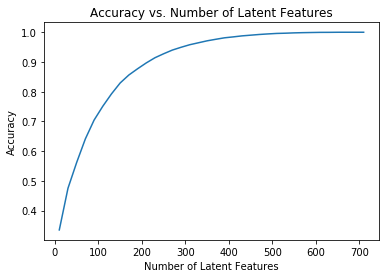

In [94]:
num_latent_feats = np.arange(10,700+14,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [95]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    #Train data
    user_item_train = df_train.drop_duplicates(keep='first')
    user_item_train = user_item_train.groupby(['user_id', 'article_id']).size().unstack()
    user_item_train = user_item_train.fillna(value=0)
    
    #Test data
    user_item_test = df_test.drop_duplicates(keep='first')
    user_item_test = user_item_test.groupby(['user_id', 'article_id']).size().unstack()
    user_item_test = user_item_test.fillna(value=0)
    
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [96]:
user_item_train.shape, user_item_test.shape, len(test_idx), len(test_arts)

((4487, 714), (682, 574), 682, 574)

In [97]:
# How many users can we make predictions for in the test set? 
common_users = pd.merge(user_item_train, user_item_test, how="inner", on="user_id").reset_index()
common_users.user_id

0     2917
1     3024
2     3093
3     3193
4     3527
5     3532
6     3684
7     3740
8     3777
9     3801
10    3968
11    3989
12    3990
13    3998
14    4002
15    4204
16    4231
17    4274
18    4293
19    4487
Name: user_id, dtype: int64

In [98]:
# How many movies can we make predictions for in the test set?
train_movies = set(user_item_train.columns)
test_movies = set(user_item_test.columns)
common_movies = 0
for i in test_movies :
    if i in train_movies:
        common_movies = common_movies+1

In [99]:
test_movies_not_in_training = len(test_movies) - common_movies
test_movies_not_in_training

0

In [100]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [101]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape



((4487, 4487), (714,), (714, 714))

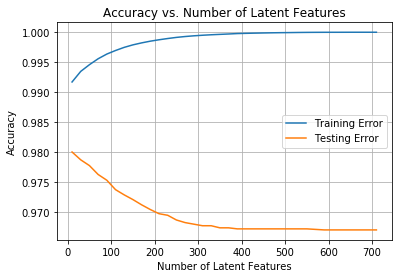

In [102]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10,700+14,20)
sum_errs = []

total_train_accuracy = list()
total_test_accuracy = list()

for k in num_latent_feats:
    
    # restructure with k latent features
    u_new, s_new, vt_new = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    
    # users that are in both training and testing sets
    common_users = user_item_train.index.intersection(user_item_test.index)
    common_users_idx = [list(user_item_train.index).index(user_id) for user_id in common_users]
    
    u_test = u_train[common_users_idx, :k]
    
    # articles that are in both training and testing sets
    train_movies = list(set(user_item_train.columns))
    test_movies = list(set(user_item_test.columns))
    
    common_articles = list() 
    common_articles_idx = list() 
    
    for i in range(len(test_movies)) :
        if test_movies[i] in train_movies:
            common_articles_idx.append(i)
            common_articles.append(test_movies[i])

    vt_test = vt_train[:k, common_articles_idx]
    
    # take dot product
    user_item_train_est= np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test, s_new), vt_test))
    
    # Get sum of all the entries where predicted
    # matrix is different from actual matrix
    train_errors = np.sum(np.sum(np.abs(np.subtract(user_item_train, user_item_train_est))))
    test_errors = np.sum(np.sum(np.abs(np.subtract(user_item_test.loc[common_users, common_articles], user_item_test_est))))
    
    total_train_accuracy.append(1 - train_errors / (user_item_train.shape[0] * user_item_train.shape[1]))
    total_test_accuracy.append(1 - test_errors / (len(common_users) * len(common_articles)))

plt.plot(num_latent_feats, total_train_accuracy, label='Training Error')
plt.plot(num_latent_feats, total_test_accuracy, label='Testing Error')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.grid();


In the above plot we can observe that fewer latent features has a better outcome than having more as the accuracy in the test set is deacresing for more features, while the accuracy for the train set is higher. This looks like a typical overfitting scenario where the prediction model learns how to predict very well the train data, but fails to generalize, i.e. having a low accuracy on test data. In order to understand if the recommendation system actually makes an improvement into recommending relevant items to the users, we could conduct A/B testing where we could use a metric such as average clicks on recommended items as more clicks could indicate that the system's recommendations were suitable for the user.